# TP2 RN

# Introducción

El objetivo del presente informe es entender dos implementaciones para hacer segmentación de imagenes. Primero se trabaja sobre una red *Atrous* o *Dilated Convolution*. Luego se muestra una implementación de la red U-NET.

Algunas modificaciones son presentadas con sus respectivas comparaciones en performance.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip drive/MyDrive/PhC-C2DH-U373.zip

Archive:  drive/MyDrive/PhC-C2DH-U373.zip
   creating: PhC-C2DH-U373/
   creating: PhC-C2DH-U373/01/
  inflating: PhC-C2DH-U373/01/t000.tif  
  inflating: PhC-C2DH-U373/01/t001.tif  
  inflating: PhC-C2DH-U373/01/t002.tif  
  inflating: PhC-C2DH-U373/01/t003.tif  
  inflating: PhC-C2DH-U373/01/t004.tif  
  inflating: PhC-C2DH-U373/01/t005.tif  
  inflating: PhC-C2DH-U373/01/t006.tif  
  inflating: PhC-C2DH-U373/01/t007.tif  
  inflating: PhC-C2DH-U373/01/t008.tif  
  inflating: PhC-C2DH-U373/01/t009.tif  
  inflating: PhC-C2DH-U373/01/t010.tif  
  inflating: PhC-C2DH-U373/01/t011.tif  
  inflating: PhC-C2DH-U373/01/t012.tif  
  inflating: PhC-C2DH-U373/01/t013.tif  
  inflating: PhC-C2DH-U373/01/t014.tif  
  inflating: PhC-C2DH-U373/01/t015.tif  
  inflating: PhC-C2DH-U373/01/t016.tif  
  inflating: PhC-C2DH-U373/01/t017.tif  
  inflating: PhC-C2DH-U373/01/t018.tif  
  inflating: PhC-C2DH-U373/01/t019.tif  
  inflating: PhC-C2DH-U373/01/t020.tif  
  inflating: PhC-C2DH-U373/01/t021.tif

In [3]:
from matplotlib import pyplot as plt
import numpy as np
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import metrics
from tensorflow.keras import backend as K

In [4]:
from PIL import Image

# Cargo Train y Val

Train será aumentado

In [5]:
train_path = Path("PhC-C2DH-U373/01/").glob("**/*tif")
val_path = Path("PhC-C2DH-U373/02/").glob("**/*tif")

In [6]:
train_images = list()
train_masks = list()
for file in train_path:
    train_images.append(np.array(Image.open(file)).reshape(1,520,696))
    train_masks.append(np.array(Image.open(f'PhC-C2DH-U373/01_ST/SEG/man_seg{file.name[1:]}')).reshape(1,520,696))

val_images = list()
val_masks = list()

for file in val_path:
    val_images.append(np.array(Image.open(file)).reshape(1,520,696))
    val_masks.append(np.array(Image.open(f'PhC-C2DH-U373/02_ST/SEG/man_seg{file.name[1:]}')).reshape(1,520,696))

In [7]:
train_images = np.vstack(train_images)/255
train_masks = 1*(np.vstack(train_masks) > 0)
val_images = np.vstack(val_images)/255
val_masks = 1*(np.vstack(val_masks) >0 )

# Imágenes de train sin aumentar

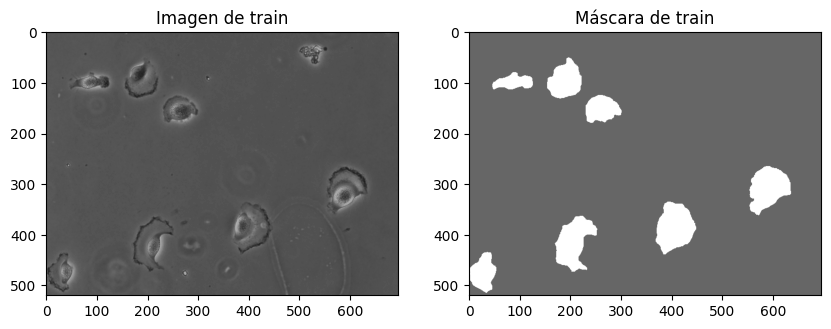

In [8]:
idx = 100

fig, axs = plt.subplots(1, 2, figsize = (10,5))

axs[0].imshow(train_images[idx], vmin=0, vmax=1, cmap="gray")
axs[0].set_title('Imagen de train')
axs[1].imshow(train_masks[idx], vmin=0, vmax=1, cmap="gray",alpha=0.6)
axs[1].set_title('Máscara de train')
plt.show()



# Armo datasets de tensorflow y aumento

Para mantener sincronizada la aumentación entre la imagen y la máscara, armo una entrada de 4 canales que de descompondrán durante el entrenamiento.

In [9]:
x_train = np.stack((train_images, train_masks ),axis=-1)
x_val = np.stack((val_images, val_masks ),axis=-1)

In [10]:
x_train[0,:,:,0].max()

0.7254901960784313

In [11]:
x_train[0,:,:,1].max()

1.0

In [12]:
len(x_train) # len de la primera dimensión

115

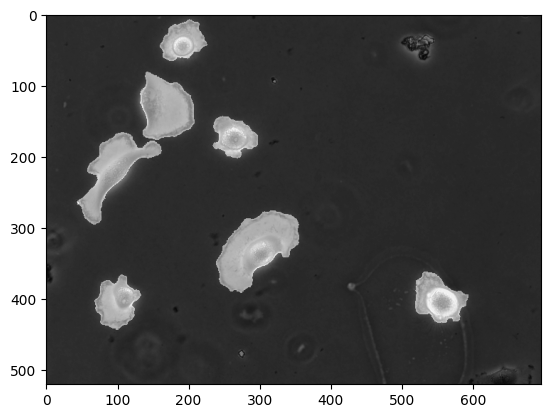

In [13]:
plt.imshow(x_train[0,:,:,0], cmap="gray")
plt.imshow(x_train[0,:,:,1], cmap="gray", alpha = 0.5)

In [14]:
from tensorflow.keras.models import Sequential

# Armo una red mínima fully convolutional con Atrous Convolutions

Para resolver un problema de segmentación, uno debe tener el mismo size a la salida y a la entrada. Dado que se espera que la salida sean pixeles coloreados(multiclase) o marcados con 1 (el caso de interés) indicando los distintos objetos presentes. Una forma de resolver esto sería *stackear* varias capas convoluciones usando *padding same*, de forma tal que el tamaño de la entrada sea igual al de la salida de cada capa. El problema de esto es que el campo perceptual crece linealmente por lo que se debería cargar gran cantidad de capas convolucionales, y esto es malo dado el exceso en la cantidad de parámetros que a su vez trae consigo la dificultad en el entrenamiento, sufriendo vanishing gradient.

Atrous convolutions, es una red que que tiene un kernel ampliado o dilatado, pero no todos sus pesos son ajustables si no que valen 0, de esta forma, se puede alcanzar un campo perceptual elevado sin tener que usar muchas capas.



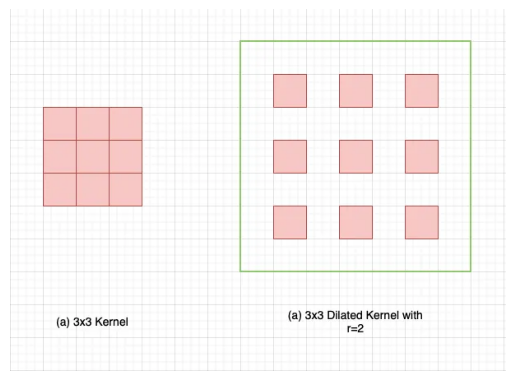

In [16]:
from PIL import Image
image_path = '/content/astr.png'
image = Image.open(image_path)
plt.imshow(image)
plt.axis('off')
plt.show()



In [17]:
filters = 16
kernel_size = 10
def get_red_seg():
    return Sequential([
        tf.keras.layers.Conv2D(filters, kernel_size,padding="same", activation = "relu", dilation_rate = 1, input_shape = (None,None,1)),
        tf.keras.layers.Conv2D(filters, kernel_size,padding="same", activation = "relu", dilation_rate = 2),
        tf.keras.layers.Conv2D(filters, kernel_size,padding="same", activation = "relu", dilation_rate = 4),
        tf.keras.layers.Conv2D(filters, kernel_size,padding="same", activation = "relu", dilation_rate = 8),
        tf.keras.layers.Conv2D(filters, kernel_size,padding="same", activation = "relu", dilation_rate = 1),
        tf.keras.layers.Conv2D(1, kernel_size,padding="same", activation = "sigmoid", dilation_rate = 1)
    ])


# Armo la red de preprocesamiento para hacer aumentación en la GPU que no tengo

In [18]:
def get_preproc():
    return Sequential([
        tf.keras.layers.RandomCrop(512,512),
        tf.keras.layers.RandomFlip(mode='horizontal_and_vertical'),
        #tf.keras.layers.RandomZoom((-0.1,0.3)),
        #tf.keras.layers.RandomTranslation((-0.5, 0.5), (-0.5,0.5)),
        #tf.keras.layers.RandomRotation((0,1)),
        #tf.keras.layers.RandomZoom((0.5,0.5)),
        ])

def get_preproc_val():
    return Sequential([
        tf.keras.layers.CenterCrop(512,512),
        ])

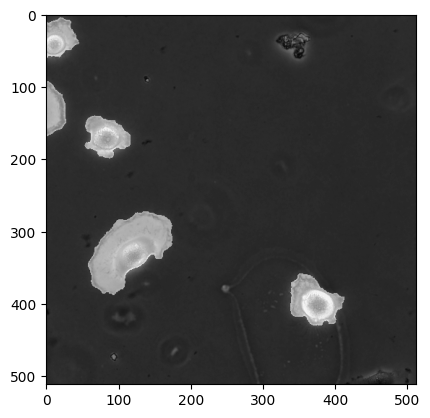

In [19]:
preproc = get_preproc()
aux_elem = preproc(x_train[0])
plt.imshow(aux_elem[:,:,0], cmap="gray")
plt.imshow(aux_elem[:,:,1], cmap="gray", alpha = 0.5)

In [20]:
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

def dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [21]:
class SegmentationModel(Model):
    def __init__(self, red_preproc, red_segmentacion, red_preproc_val, dice = False):
        super().__init__()
        self.red_segmentacion = red_segmentacion
        self.red_preproc = red_preproc
        self.red_preproc_val = red_preproc_val
        self.loss_tracker = metrics.Mean(name="loss")
        self.dice = dice


    def call(self, inputs):
        #img_mask = self.red_preproc = red_preproc(inputs)
        return self.red_segmentacion(inputs[:,:,:1])

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            data_aug = self.red_preproc(data)
            loss = self._compute_loss(data_aug)
            #print(K.mean(loss))

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.red_segmentacion.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.red_segmentacion.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        data_preproc = self.red_preproc_val(data)
        loss = self._compute_loss(data_preproc)
        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        #aux = self.red_preproc(data)
        mask_out = self.red_segmentacion(data[:,:,:,:1])
        #print(mask_out.shape)
        #print(data[:,:,:,1:2].numpy())
        if self.dice == True:
            loss = dice_loss(data[:,:,:,1:2], mask_out)
        else:
            loss = tf.keras.losses.binary_crossentropy(data[:,:,:,1:2], mask_out)
        return loss

    # property
    # def metrics(self):
    #     # We need to list our metrics here so the `reset_states()` can be
    #     # called automatically.
    #     return [self.loss_tracker]

In [22]:
red_falopa = get_red_seg()

In [23]:
red_falopa.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, None, None, 16)    1616      
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 16)    25616     
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 16)    25616     
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 16)    25616     
                                                                 
 conv2d_4 (Conv2D)           (None, None, None, 16)    25616     
                                                                 
 conv2d_5 (Conv2D)           (None, None, None, 1)     1601      
                                                                 
Total params: 105,681
Trainable params: 105,681
Non-tr

In [24]:
preproc= get_preproc()
preproc_val = get_preproc_val()
red_falopa = get_red_seg()
model = SegmentationModel(preproc, red_falopa,preproc_val)

In [25]:
model.compile(optimizer= tf.keras.optimizers.Adam(1e-4))

In [26]:
len(x_val)

115

In [27]:
model.fit(np.vstack([x_train, x_val]),batch_size=16, epochs=33, validation_split = 0.5, verbose = 1)

Epoch 1/33
8/8 [==============================] - 72s 2s/step - loss: 0.6851 - val_loss: 0.6457
Epoch 2/33
8/8 [==============================] - 9s 1s/step - loss: 0.5814 - val_loss: 0.3433
Epoch 3/33
8/8 [==============================] - 8s 1s/step - loss: 0.3633 - val_loss: 0.1715
Epoch 4/33
8/8 [==============================] - 8s 1s/step - loss: 0.3655 - val_loss: 0.2443
Epoch 5/33
8/8 [==============================] - 9s 1s/step - loss: 0.3504 - val_loss: 0.2131
Epoch 6/33
8/8 [==============================] - 8s 1s/step - loss: 0.3372 - val_loss: 0.1874
Epoch 7/33
8/8 [==============================] - 8s 1s/step - loss: 0.3284 - val_loss: 0.2076
Epoch 8/33
8/8 [==============================] - 9s 1s/step - loss: 0.3328 - val_loss: 0.1948
Epoch 9/33
8/8 [==============================] - 8s 1s/step - loss: 0.3291 - val_loss: 0.1941
Epoch 10/33
8/8 [==============================] - 8s 1s/step - loss: 0.3247 - val_loss: 0.1957
Epoch 11/33
8/8 [==============================]

In [28]:
pred = red_falopa(x_val[0:1,:,:,0])
pred.shape

TensorShape([1, 520, 696, 1])

In [29]:
pred.numpy().max()

0.94406325

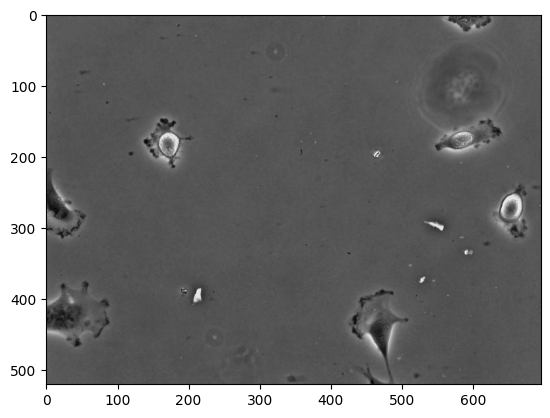

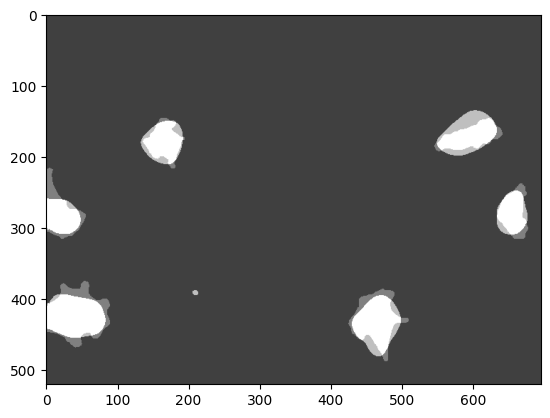

In [30]:
plt.imshow(x_val[0,:,:,0], cmap="gray")
plt.show()
plt.imshow(x_val[0,:,:,1], cmap="gray", alpha=0.5)
plt.imshow(pred[0,:,:,0]>0.5, cmap="gray", alpha=0.5)
plt.show()

# U-NET

La U-NET a diferencia de la red anterior, no mantiene siempre la misma dimensión de la imagen, usa un encoder y un decoder. Por lo tanto primero aplica capas de *max pooling* y luego *up-convolutions*. Hay una realimentación entre capas que intuyo lograría lidiar con la pérdida de información espacial.

En el paper original, usan una weighted loss para penalizar los bordes y asi poder tener una "buena frontera". Además recomiendan el uso de data augmentation, realizando shifteos, rotaciones y variaciones en los grises. Una augmentation que recomiendan fuertemente es el uso de *random elastic deformations*.

Para este informe, se realizará una evaluación para el caso del uso de otra función de costo, como el Dice. El Dice difiere de la binary crossentropy y se espera compararlos para una determinada cantidad de epochs.

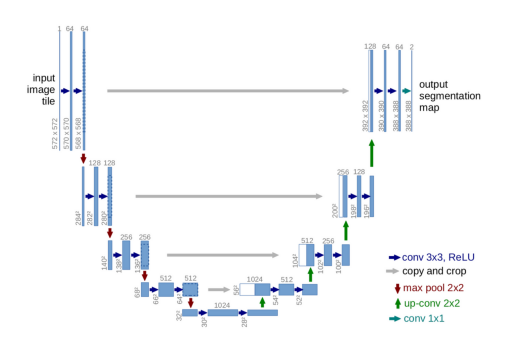

In [35]:
from PIL import Image
image_path = '/content/UNET.png'
image = Image.open(image_path)
plt.imshow(image)
plt.axis('off')
plt.show()


In [28]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dropout, Concatenate, MaxPooling2D, UpSampling2D,Conv2DTranspose

In [29]:
img_shape = (512, 512, 1)
def conv_block(m, dim, acti, bn, res, do=0):
	n = Conv2D(dim, 3, activation=acti, padding='same')(m)
	n = BatchNormalization()(n) if bn else n
	n = Dropout(do)(n) if do else n
	n = Conv2D(dim, 3, activation=acti, padding='same')(n)
	n = BatchNormalization()(n) if bn else n
	return Concatenate()([m, n]) if res else n

def level_block(m, dim, depth, inc, acti, do, bn, mp, up, res):
	if depth > 0:
		n = conv_block(m, dim, acti, bn, res)
		m = MaxPooling2D()(n) if mp else Conv2D(dim, 3, strides=2, padding='same')(n)
		m = level_block(m, int(inc*dim), depth-1, inc, acti, do, bn, mp, up, res)
		if up:
			m = UpSampling2D()(m)
			m = Conv2D(dim, 2, activation=acti, padding='same')(m)
		else:
			m = Conv2DTranspose(dim, 3, strides=2, activation=acti, padding='same')(m)
		n = Concatenate()([n, m])
		m = conv_block(n, dim, acti, bn, res)
	else:
		m = conv_block(m, dim, acti, bn, res, do)
	return m

def UNet(img_shape, out_ch=1, start_ch=64, depth=4, inc_rate=2., activation='relu',
		 dropout=0.5, batchnorm=False, maxpool=True, upconv=True, residual=False):
	i = Input(shape=img_shape)
	o = level_block(i, start_ch, depth, inc_rate, activation, dropout, batchnorm, maxpool, upconv, residual)
	o = Conv2D(out_ch, 1, activation='sigmoid')(o)
	return Model(inputs=i, outputs=o)

# Con Binary Crossentropy con Loss




In [28]:
preproc_unet= get_preproc()
preproc_unet_val= get_preproc_val()
red_unet = UNet(
    img_shape,
    start_ch = 16,
    dropout = False,
    residual = True
)
model_unet = SegmentationModel(preproc_unet, red_unet,preproc_unet_val)

In [29]:
model_unet.compile(optimizer= tf.keras.optimizers.Adam(1e-4))

In [30]:
history = model_unet.fit(np.vstack([x_train, x_val]),batch_size=16, epochs=50, validation_split = 0.5, verbose = 1)

Epoch 1/50
8/8 [==============================] - 55s 3s/step - loss: 0.6571 - val_loss: 0.5976
Epoch 2/50
8/8 [==============================] - 11s 1s/step - loss: 0.5628 - val_loss: 0.3937
Epoch 3/50
8/8 [==============================] - 11s 1s/step - loss: 0.3927 - val_loss: 0.1868
Epoch 4/50
8/8 [==============================] - 11s 1s/step - loss: 0.3597 - val_loss: 0.2614
Epoch 5/50
8/8 [==============================] - 11s 1s/step - loss: 0.3538 - val_loss: 0.1949
Epoch 6/50
8/8 [==============================] - 11s 1s/step - loss: 0.3424 - val_loss: 0.2219
Epoch 7/50
8/8 [==============================] - 11s 1s/step - loss: 0.3346 - val_loss: 0.2033
Epoch 8/50
8/8 [==============================] - 11s 1s/step - loss: 0.3325 - val_loss: 0.2029
Epoch 9/50
8/8 [==============================] - 12s 1s/step - loss: 0.3340 - val_loss: 0.2017
Epoch 10/50
8/8 [==============================] - 12s 1s/step - loss: 0.3247 - val_loss: 0.1918
Epoch 11/50
8/8 [======================

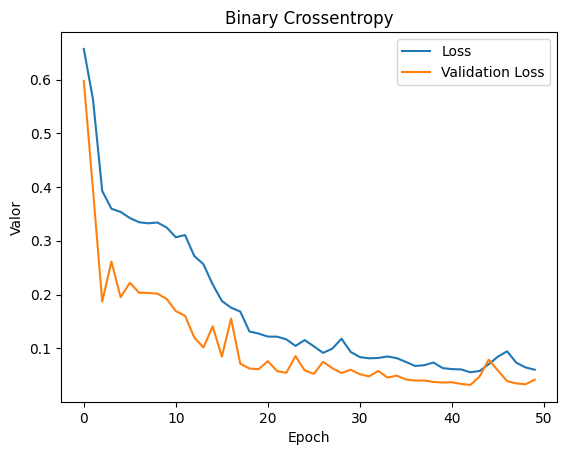

In [32]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Valor')
plt.title('Binary Crossentropy')
plt.legend()
plt.show()

In [ ]:
red_unet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_23 (Conv2D)             (None, 512, 512, 16  160         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_24 (Conv2D)             (None, 512, 512, 16  2320        ['conv2d_23[0][0]']              
                                )                                                           

# Con Dice como Loss

In [30]:
preproc_unet= get_preproc()
preproc_unet_val= get_preproc_val()
red_unet = UNet(
    img_shape,
    start_ch = 16,
    dropout = False,
    residual = True
)
model_unet = SegmentationModel(preproc_unet, red_unet,preproc_unet_val, dice = True)

In [31]:
model_unet.compile(optimizer= tf.keras.optimizers.Adam(1e-4))

In [32]:
history = model_unet.fit(np.vstack([x_train, x_val]),batch_size=16, epochs=50, validation_split = 0.5, verbose = 1)

Epoch 1/50
8/8 [==============================] - 57s 3s/step - loss: 0.8418 - val_loss: 0.9325
Epoch 2/50
8/8 [==============================] - 11s 1s/step - loss: 0.8367 - val_loss: 0.9309
Epoch 3/50
8/8 [==============================] - 11s 1s/step - loss: 0.8321 - val_loss: 0.9289
Epoch 4/50
8/8 [==============================] - 11s 1s/step - loss: 0.8337 - val_loss: 0.9283
Epoch 5/50
8/8 [==============================] - 11s 1s/step - loss: 0.8279 - val_loss: 0.9269
Epoch 6/50
8/8 [==============================] - 11s 1s/step - loss: 0.8208 - val_loss: 0.9249
Epoch 7/50
8/8 [==============================] - 11s 1s/step - loss: 0.8145 - val_loss: 0.9143
Epoch 8/50
8/8 [==============================] - 12s 1s/step - loss: 0.7812 - val_loss: 0.8918
Epoch 9/50
8/8 [==============================] - 12s 1s/step - loss: 0.7442 - val_loss: 0.8825
Epoch 10/50
8/8 [==============================] - 12s 1s/step - loss: 0.7400 - val_loss: 0.8709
Epoch 11/50
8/8 [======================

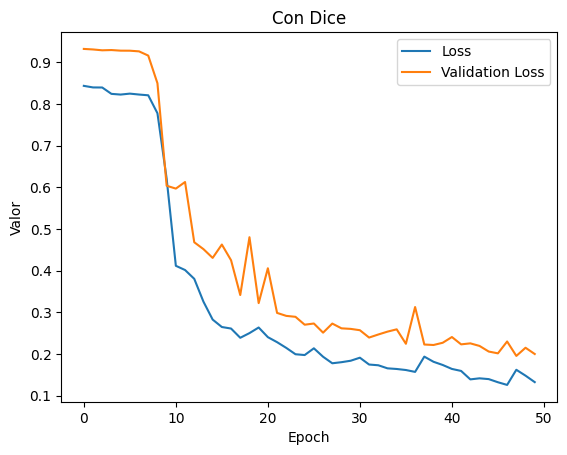

In [31]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Valor')
plt.title('Con Dice')
plt.legend()
plt.show()

# Resultados para Binary Crossentropy

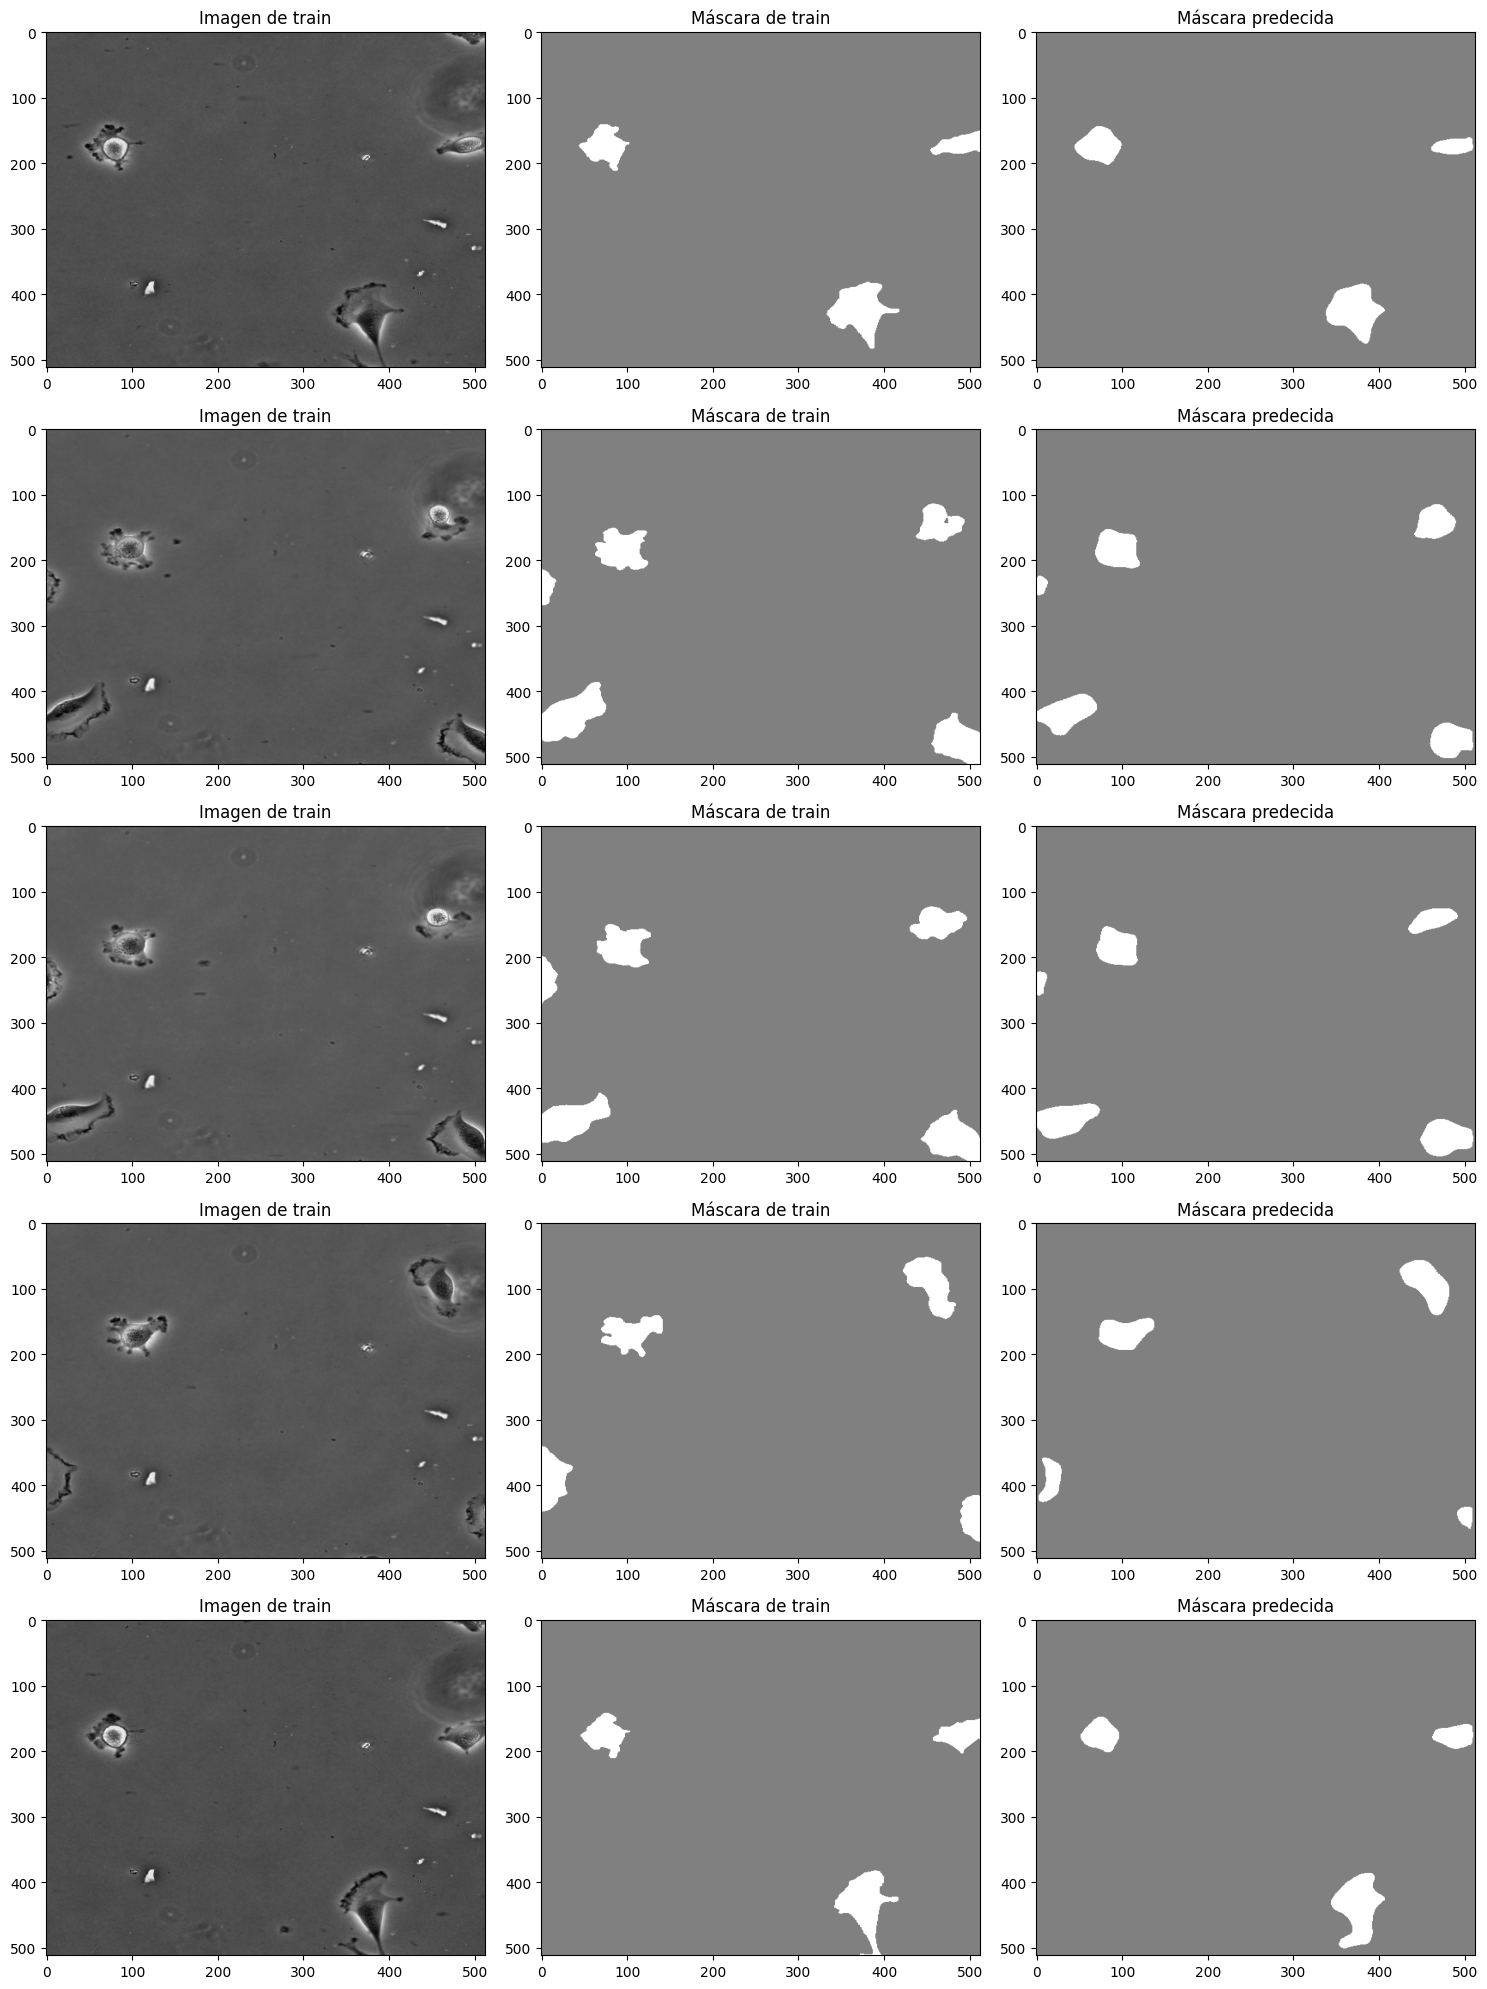

In [51]:
aux = preproc_unet_val(x_val[0:5,:,:,:])
pred = red_unet(aux[0:5,:,:,0])
pred.shape
fig, axs = plt.subplots(5, 3, figsize = (15,20))

for i in range(5):
  axs[i][0].imshow(aux[i,:,:,0], cmap="gray")
  axs[i][0].set_title('Imagen de train')
  axs[i][1].imshow(aux[i,:,:,1], cmap="gray", alpha = 0.5)
  axs[i][1].set_title('Máscara de train')
  axs[i][2].imshow(pred[i,:,:,0]>0.7, cmap="gray", alpha = 0.5)
  axs[i][2].set_title('Máscara predecida')
  # Increase image size
  axs[i][0].set_aspect('auto')
  axs[i][1].set_aspect('auto')
  axs[i][2].set_aspect('auto')


plt.tight_layout()
plt.show()

# Resultados para Dice

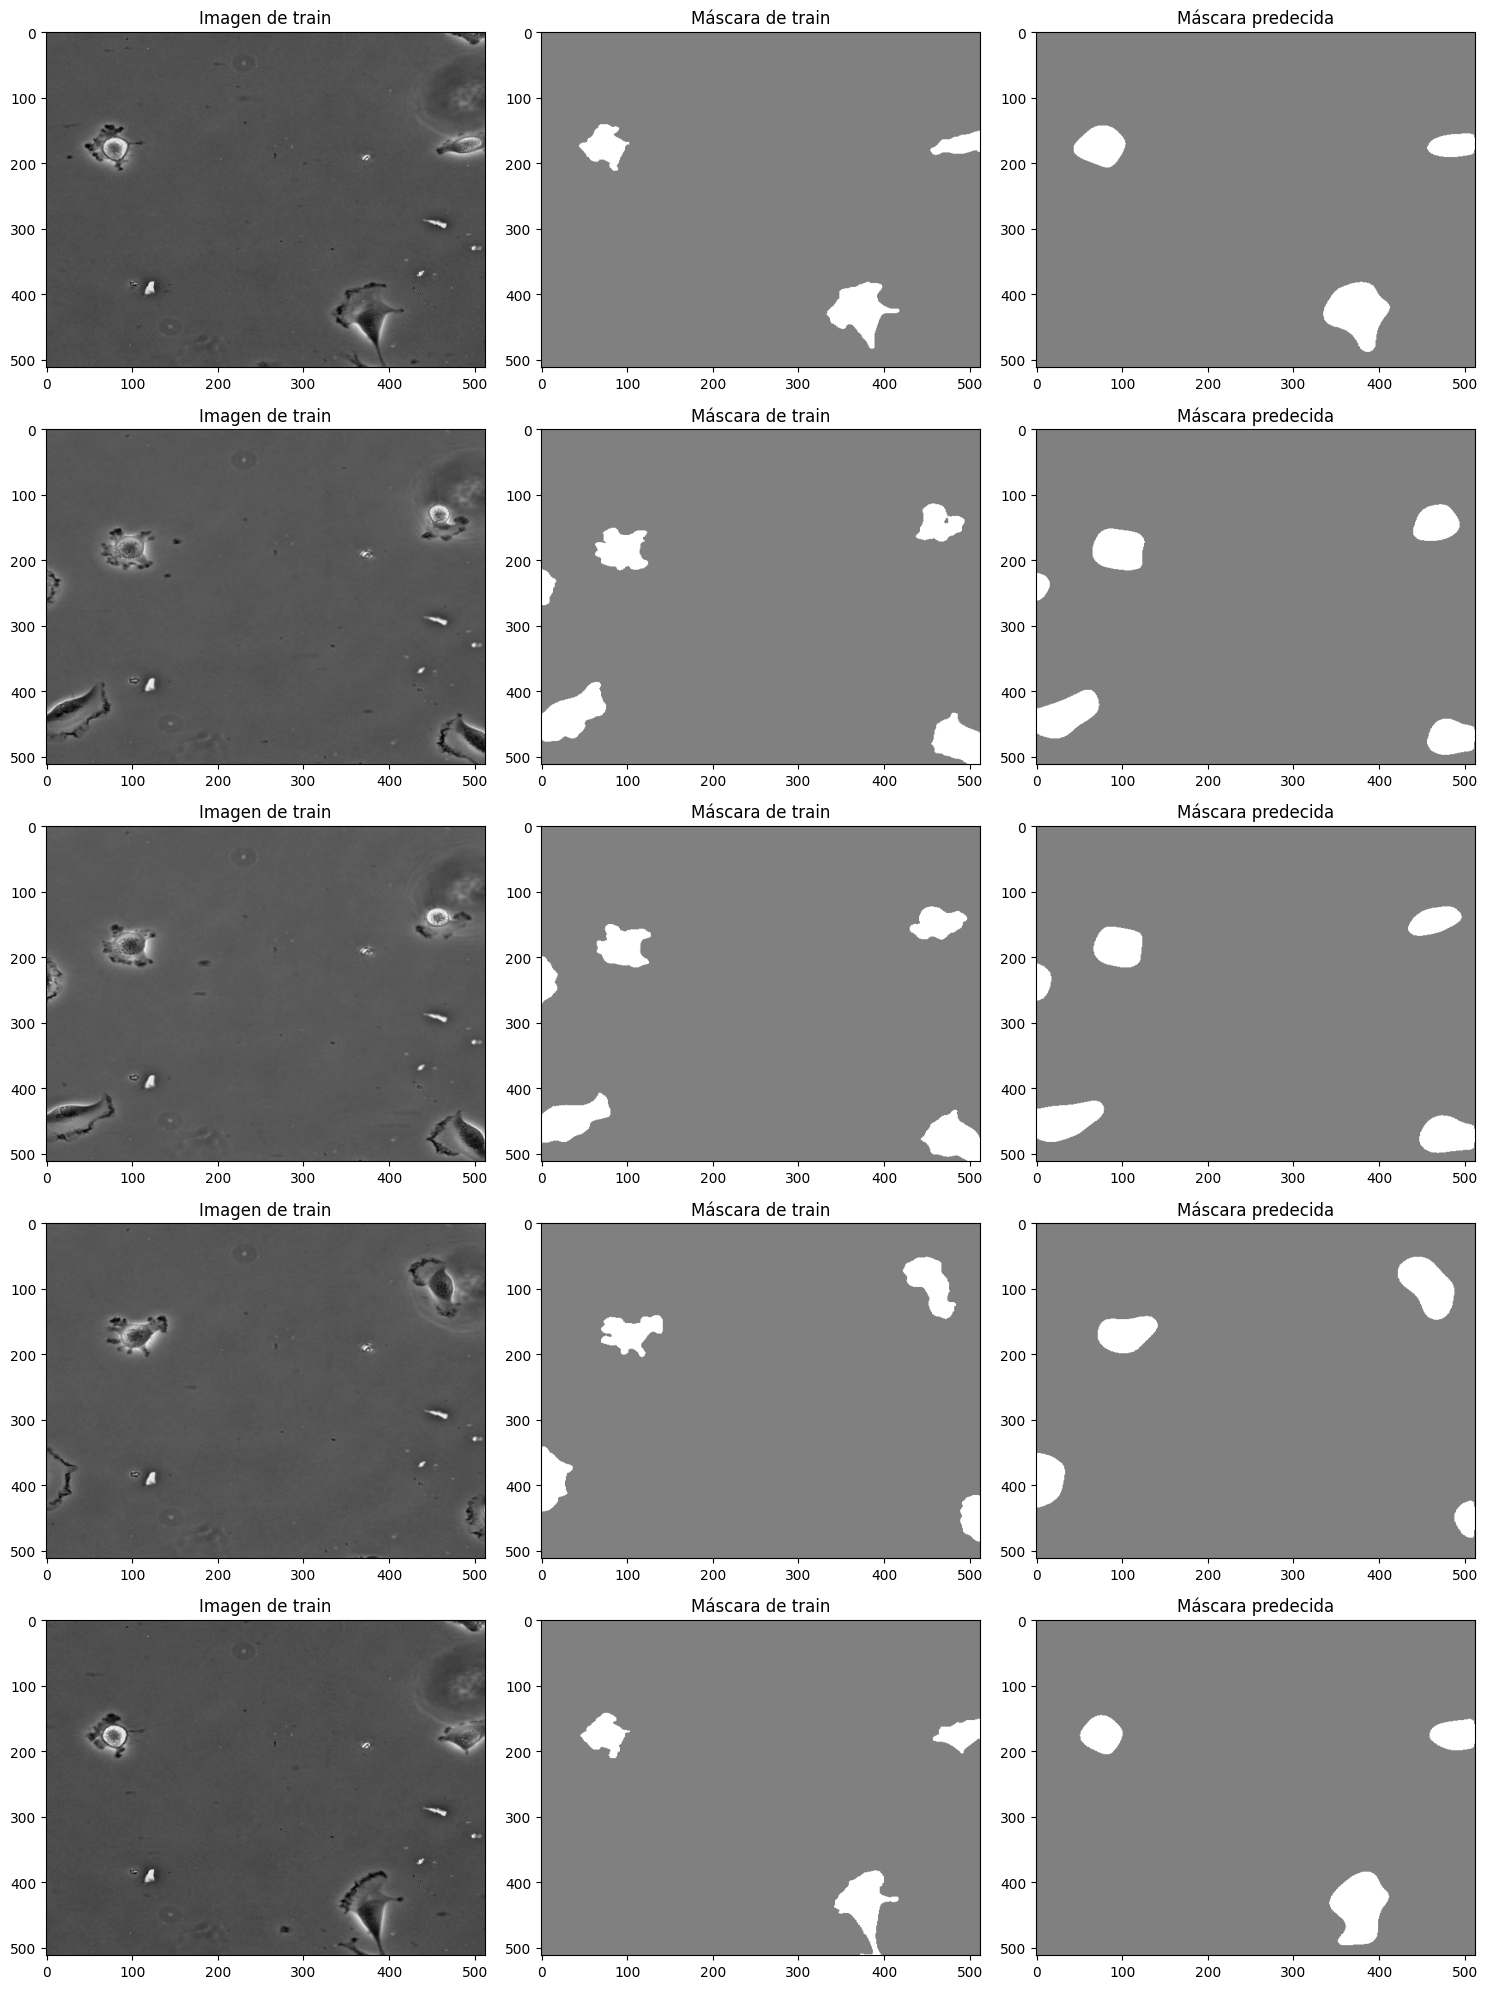

In [34]:
aux = preproc_unet_val(x_val[0:5,:,:,:])
pred = red_unet(aux[0:5,:,:,0])
pred.shape
fig, axs = plt.subplots(5, 3, figsize = (15,20))

for i in range(5):
  axs[i][0].imshow(aux[i,:,:,0], cmap="gray")
  axs[i][0].set_title('Imagen de train')
  axs[i][1].imshow(aux[i,:,:,1], cmap="gray", alpha = 0.5)
  axs[i][1].set_title('Máscara de train')
  axs[i][2].imshow(pred[i,:,:,0]>0.7, cmap="gray", alpha = 0.5)
  axs[i][2].set_title('Máscara predecida')
  # Increase image size
  axs[i][0].set_aspect('auto')
  axs[i][1].set_aspect('auto')
  axs[i][2].set_aspect('auto')


plt.tight_layout()
plt.show()

# Conclusiones

Dado que las loss functions son distintas, no tiene sentido comparar por valor mínimo para decir cual es mejor. Aunque haciendo un análisis visual de las imágenes anteriores notamos que las predicciones con Dice suelen ser mas suavizadas, sin tantos detalles. Por lo tanto, para la misma cantidad de Epoch, podemos concluir que la binary crossentropy performa mejor.